## Clustering

Working with Unlabeled Data – Clustering Analysis

[Reference](https://github.com/rasbt/machine-learning-book/blob/main/ch10/ch10.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

### K-means clustering using scikit-learn

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

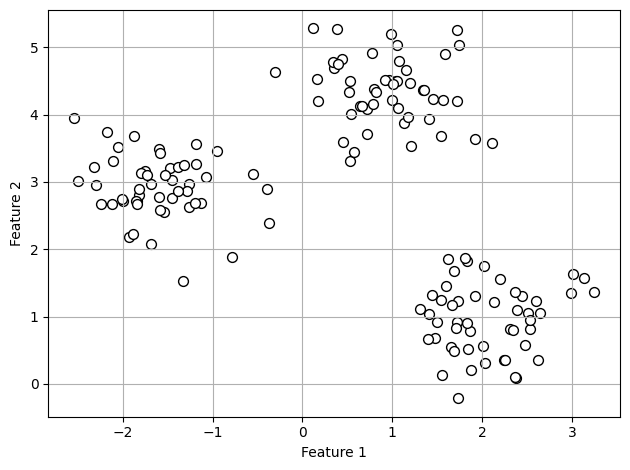

In [4]:
plt.scatter(X[:, 0], X[:, 1],
            c='white', marker='o', edgecolor='black', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.grid()
plt.tight_layout()
#plt.savefig('figures/10_01.png', dpi=300)
plt.show()

In [5]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

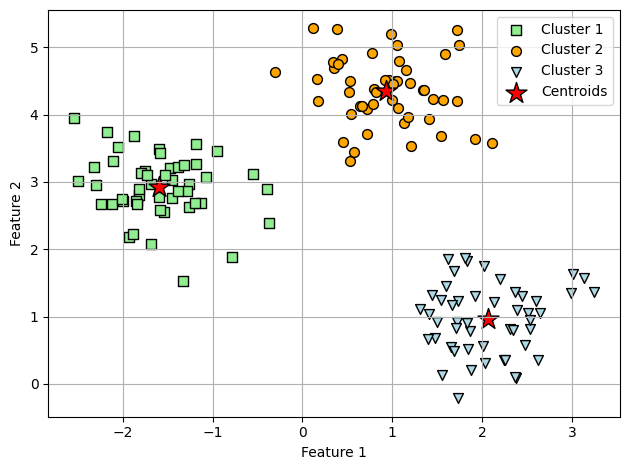

In [6]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('figures/10_02.png', dpi=300)
plt.show()

### More research to do with:

- A smarter way of placing the initial cluster centroids using k-means++
- Hard versus soft clustering


### Using the elbow method to find the optimal number of clusters

- Distortion is the average of the euclidean squared distance from the centroid of the respective clusters.
- Inertia is the sum of squared distances of samples to their closest cluster centre.

In [7]:
# What is the 'distortion'?
print(f'Distortion: {km.inertia_:.2f}')

Distortion: 72.48


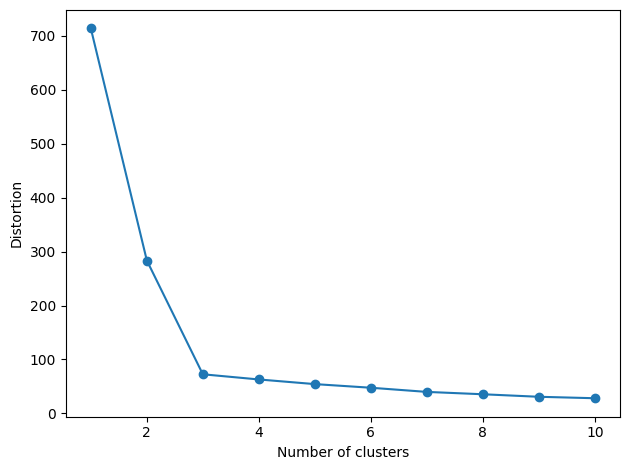

In [8]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### Quantifying the quality of clustering via silhouette plots

The Silhouette method evaluates clustering quality by considering how well each data point fits within its assigned cluster compared to other clusters.

**Silhouette Coefficient:**

For each data point:

- - Calculate (ai): the average distance to all other points in its own cluster (cohesion).

Calculate (bi): the average distance to all points in the nearest neighboring cluster (separation).

- The Silhouette Coefficient for that point is:

$$
\frac{b_i - a_i}{\max(a_i, b_i)}
$$

Close to 1: Point is well-clustered.
Close to 0: Point is near the decision boundary between clusters.
Close to -1: Point might be in the wrong cluster.  


**Global Silhouette Coefficient:**

The average of all individual Silhouette Coefficients provides an overall measure of clustering quality:

Close to 1: Good clustering (well-separated and cohesive clusters).
Close to -1: Poor clustering (significant overlap or misclassification).
Close to 0: Overlapping clusters or unclear clustering.

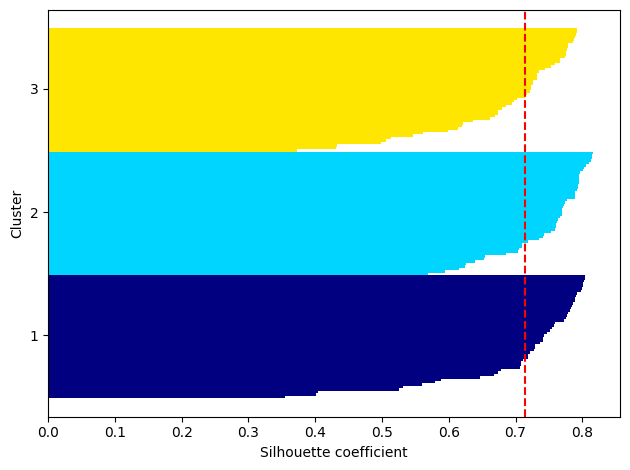

In [9]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

### Organizing clusters as a hierarchical tree
- Grouping clusters in bottom-up fashion

In [10]:
np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [11]:
# Performing hierarchical clustering on a distance matrix
from scipy.spatial.distance import pdist, squareform


row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [12]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=[f'cluster {(i + 1)}'
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


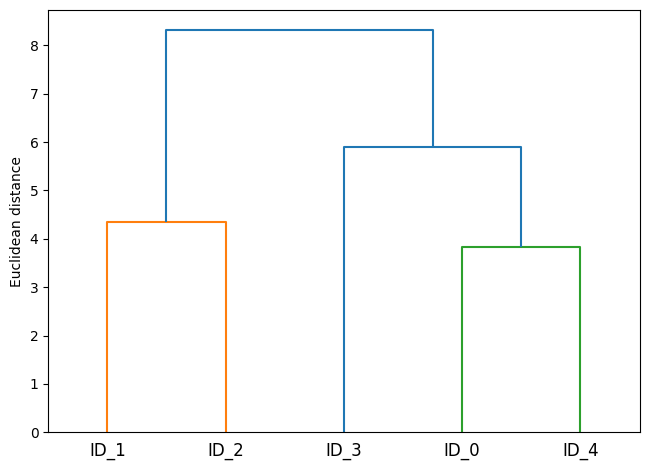

In [13]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters,
                       labels=labels,
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

### Locating regions of high density via DBSCAN

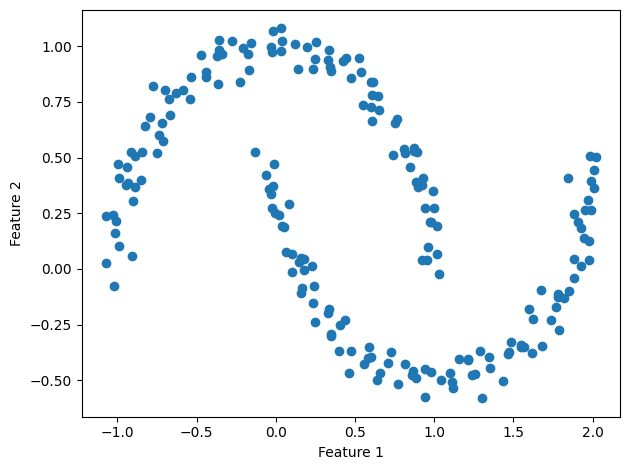

In [14]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

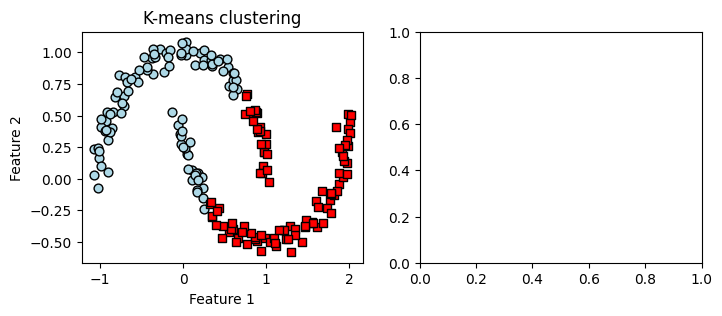

In [15]:
from sklearn.cluster import AgglomerativeClustering

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.legend()
plt.tight_layout()
plt.show()

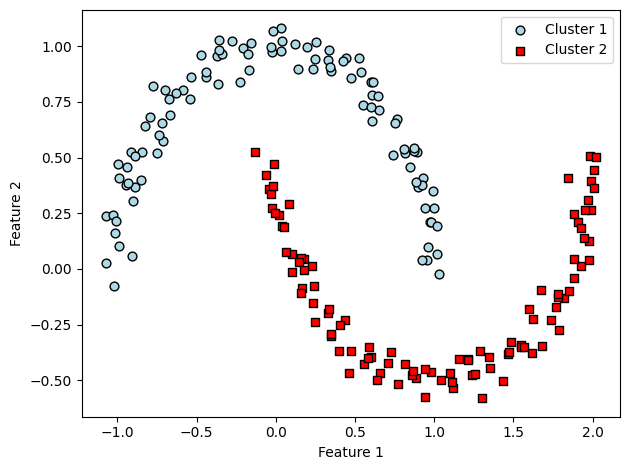

In [16]:
# Density-based clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black',
            label='Cluster 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend()
plt.tight_layout()
plt.show()

## Your work

Task 1: Execute the provided code in your notebook to observe how the silhouette score aids in selecting the optimal number of clusters in K-means.

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html




Task 2: Execute the provided code in your notebook to observe which clustering algorithms are suitable for different data structures.

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

Submit your notebook in PDF format to BrightSpace by 5/4/2025 11:50 pm.

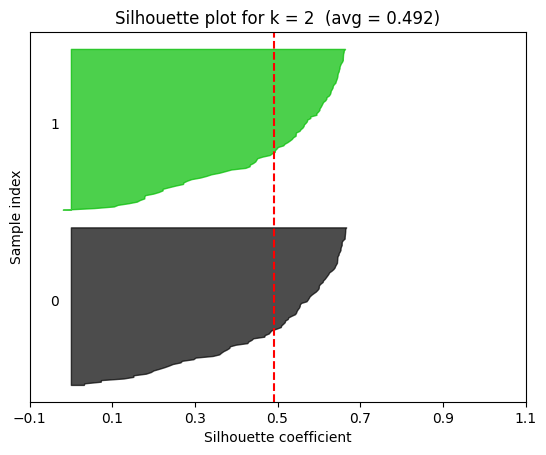

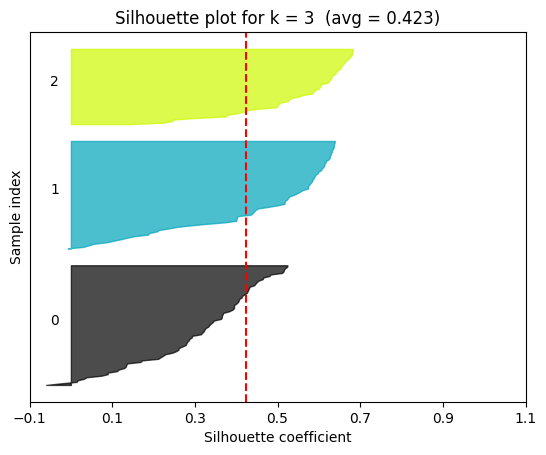

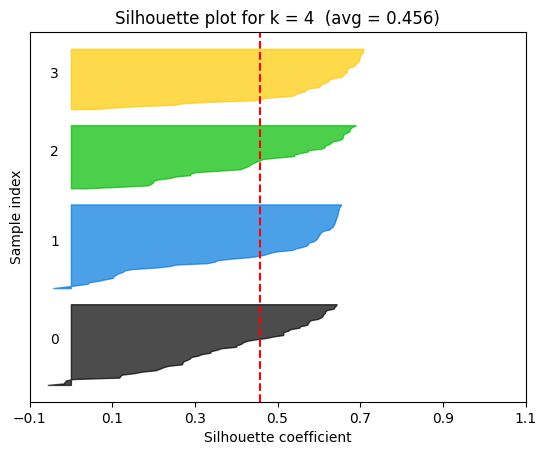

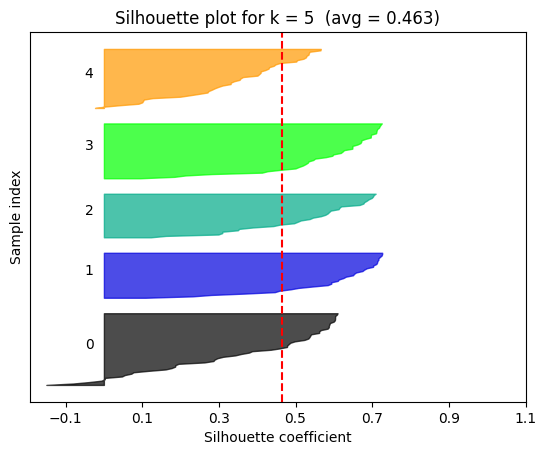

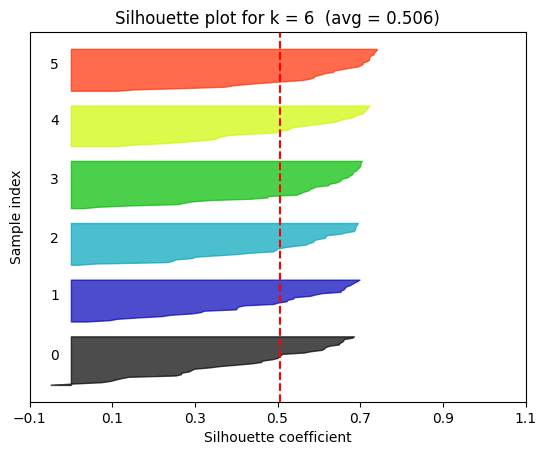

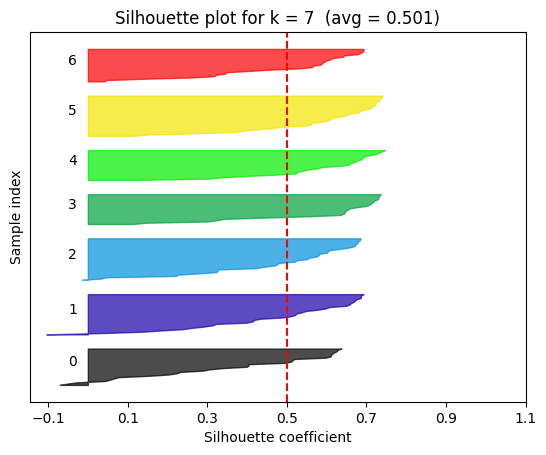

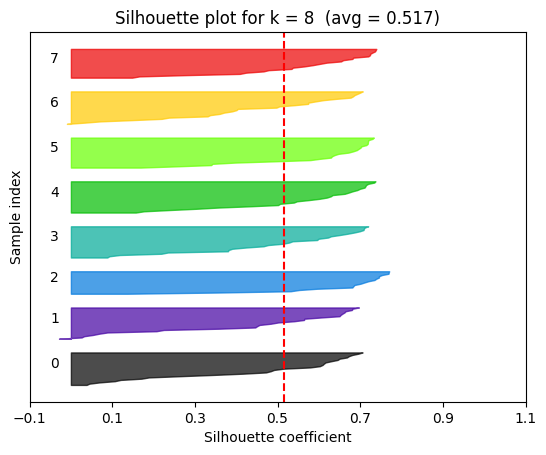

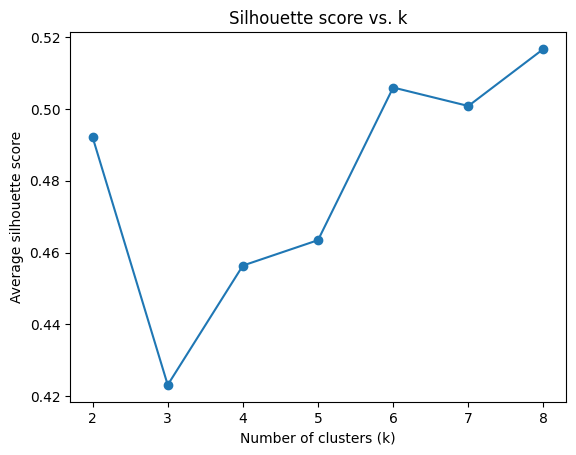

In [17]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = range(2, 9)   # test k = 2 … 8
silhouette_avgs = []

for k in range_n_clusters:
    fig, ax = plt.subplots()

    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)

    sil_avg = silhouette_score(X, labels)
    silhouette_avgs.append(sil_avg)
    sil_vals = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(k):
        ith_vals = np.sort(sil_vals[labels == i])
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10   # space between clusters

    ax.axvline(sil_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette plot for k = {k}  (avg = {sil_avg:.3f})")
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Sample index")
    ax.set_yticks([])  # clear y-axis
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show()

# 🔍  how the average silhouette changes with k
plt.figure()
plt.plot(list(range_n_clusters), silhouette_avgs, marker="o")
plt.xticks(list(range_n_clusters))
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette score")
plt.title("Silhouette score vs. k")
plt.show()


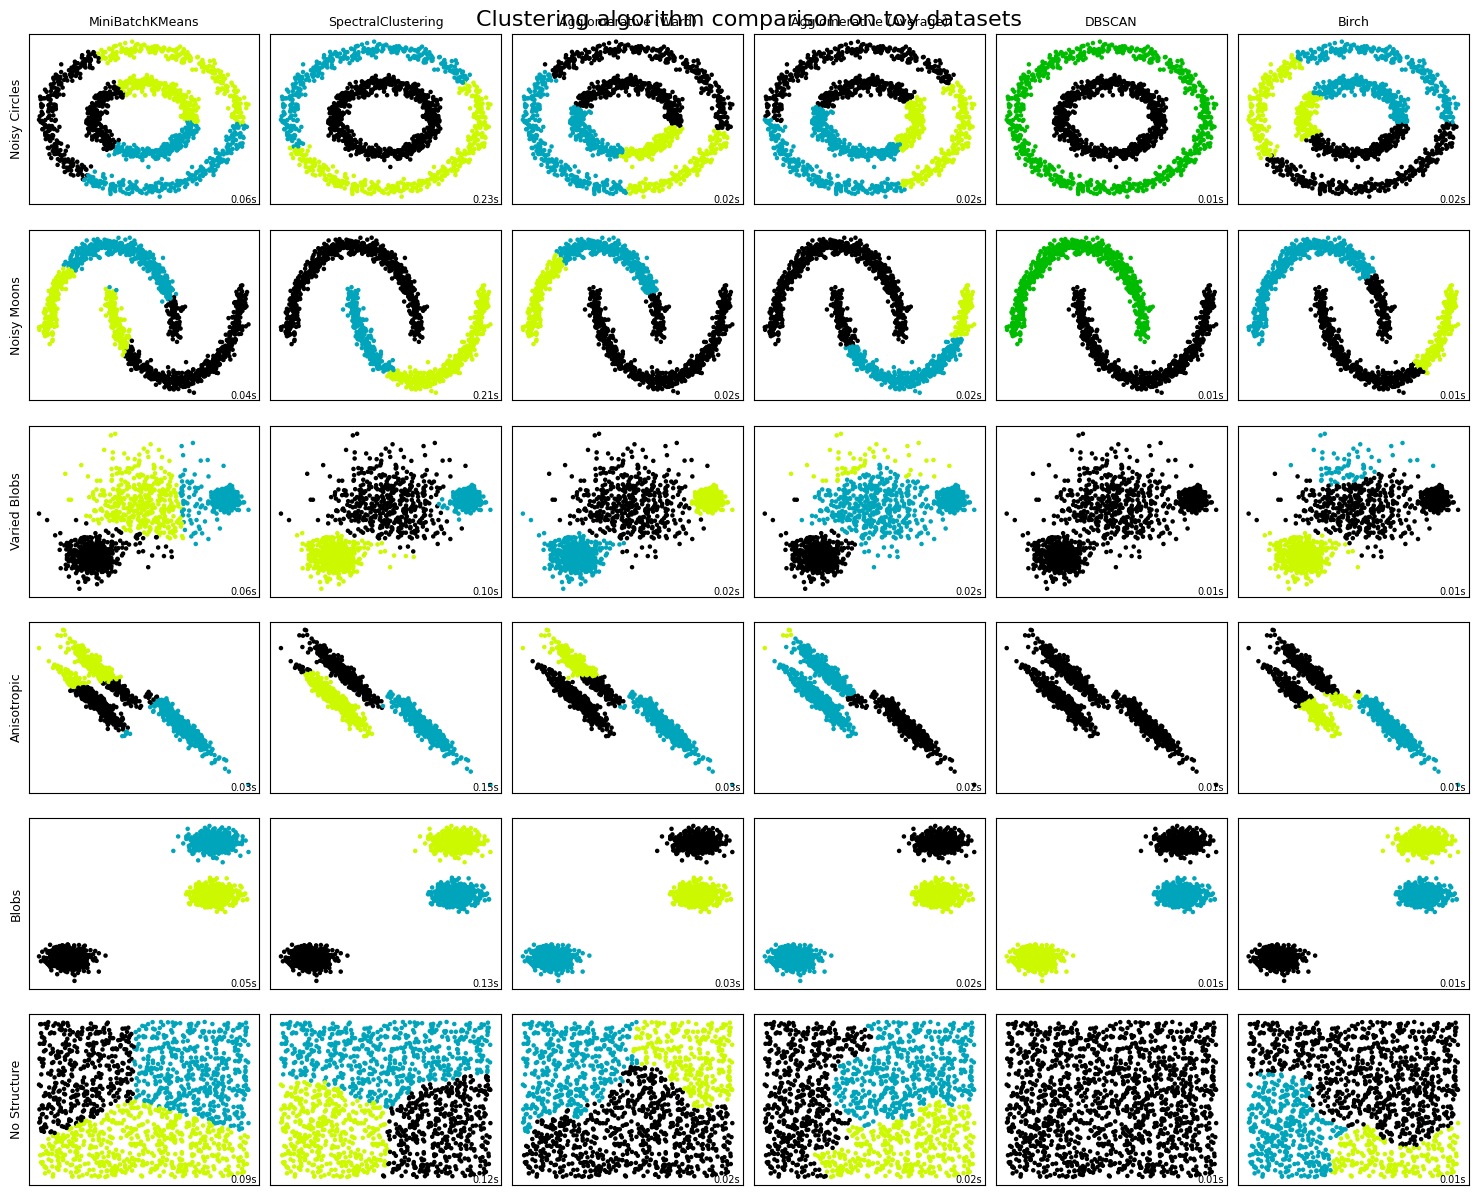

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
import time
import warnings

warnings.filterwarnings("ignore")
n_samples = 1500
random_state = 170

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons   = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs         = datasets.make_blobs(n_samples=n_samples, random_state=8)

# anisotropicly distributed data
X, y          = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso       = np.dot(X, transformation)
anisotropic   = (X_aniso, y)

#varied variance blobs
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

#uniform random data (no structure)
no_structure = (np.random.rand(n_samples, 2), None)

datasets_list = [
    noisy_circles,
    noisy_moons,
    varied,
    anisotropic,
    blobs,
    no_structure
]

dataset_names = [
    "Noisy Circles", "Noisy Moons", "Varied Blobs",
    "Anisotropic", "Blobs", "No Structure"
]

algorithms = [
    ("MiniBatchKMeans",     cluster.MiniBatchKMeans(n_clusters=3, n_init="auto", random_state=0)),
    ("SpectralClustering",  cluster.SpectralClustering(n_clusters=3, affinity="nearest_neighbors", random_state=0)),
    ("Agglomerative (Ward)", cluster.AgglomerativeClustering(n_clusters=3, linkage="ward")),
    ("Agglomerative (Average)", cluster.AgglomerativeClustering(n_clusters=3, linkage="average")),
    ("DBSCAN",              cluster.DBSCAN(eps=0.3)),
    ("Birch",               cluster.Birch(n_clusters=3))
]

fig, axes = plt.subplots(len(datasets_list), len(algorithms), figsize=(15, 12), sharex=False, sharey=False)
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.15)

for row_idx, (dataset, ds_name) in enumerate(zip(datasets_list, dataset_names)):
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    for col_idx, (algo_name, algorithm) in enumerate(algorithms):
        t0 = time.time()
        # Some algorithms can't handle noisy labels - we catch exceptions just in case
        try:
            # fit_predict returns cluster labels
            y_pred = algorithm.fit_predict(X)
        except Exception as e:
            y_pred = np.zeros_like(X[:, 0])
        
        t1 = time.time()
        ax = axes[row_idx, col_idx]
        colors = np.array(
            [plt.cm.nipy_spectral(float(i) / max(y_pred.max() + 1, 1)) for i in y_pred]
        )
        ax.scatter(X[:, 0], X[:, 1], s=5, color=colors)

        if row_idx == 0:
            ax.set_title(algo_name, fontsize=9)
        if col_idx == 0:
            ax.set_ylabel(ds_name, fontsize=9)
        
        ax.text(.99, .01, f"{(t1 - t0):.2f}s", transform=ax.transAxes,
                size=7, horizontalalignment='right')
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle("Clustering algorithm comparison on toy datasets", fontsize=16)
plt.show()
